In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive


class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        mnist_train = datasets.MNIST(root='./mnist_data/', train=True, download=True)
        self.data = mnist_train.data.reshape(-1, 1, 28, 28).float() / 255.0

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Sat Dec 26 12:29:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# my implementation is the simple version of https://github.com/kkleidal/GatedPixelCNNPyTorch (if i correctly implement)
class MaskedConv2d(nn.Module):
    def __init__(self, mask_type, vertical, Cin, Cout, kernal_size):
        super().__init__()
        assert mask_type in {'A', 'B'}
        if vertical:
            self.weight = nn.Parameter(torch.randn(Cout, Cin, kernal_size, kernal_size)).to(device)
            self.padding = (kernal_size//2, kernal_size//2)
            self.mask = torch.ones_like(self.weight)
            self.mask[:, :, kernal_size//2:, :] = 0.0
        else:
            self.weight = nn.Parameter(torch.randn(Cout, Cin, 1, kernal_size)).to(device)
            self.padding = (0, kernal_size // 2)
            self.mask = torch.ones_like(self.weight)
            if mask_type == 'A':
                self.mask[:, :, 0, (kernal_size//2):] = 0.0 
            else :
                self.mask[:, :, 0, (kernal_size//2) + 1:] = 0.0 
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        self.weight.data *= self.mask
        return F.conv2d(x, self.weight, stride=1, padding=self.padding)

class GatedPixelCNN(nn.Module):
    def __init__(self, mask_type, C, kernal_size):
        super().__init__()
        self.C = C
        self.vertical = MaskedConv2d(mask_type, True,  C, 2 * C, kernal_size)
        self.horizont = MaskedConv2d(mask_type, False, C, 2 * C, kernal_size)
        self.v2c = nn.Conv2d(2*C, 2*C, (1, 1), (1, 1), (0, 0))
        self.hor_end = nn.Conv2d(C, C, (1, 1), (1, 1), (0, 0))
        self.vbn = nn.BatchNorm2d(C)
        self.hbn = nn.BatchNorm2d(C)

    def forward(self, v, h):
        v = self.vertical(v)
        h_new = self.horizont(h)
        h_new = h_new + self.v2c(h_new)
        v = torch.tanh(v[:, :self.C, :, :]) * torch.sigmoid(v[:, self.C:, :, :])
        h_new = torch.tanh(h_new[:, :self.C, :, :]) * torch.sigmoid(h_new[:, self.C:, :, :])
        h_new = self.hor_end(h_new)
        return self.vbn(v), self.hbn(h + h_new)

class PixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, 16, 1, 1, 0),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
            ),
            GatedPixelCNN('A', 16, 7),
            GatedPixelCNN('B', 16, 7),
            GatedPixelCNN('B', 16, 7),
            GatedPixelCNN('B', 16, 7),
            nn.Sequential(
                nn.Conv2d(32, 16, 1, 1, 0),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.Conv2d(16, 1, 1, 1, 0),
                nn.Sigmoid() # i didn't use softmax
            )
        ])
    
    def forward(self, x):
        x = self.net[0](x)
        v, h = self.net[1](x, x)
        v, h = self.net[2](v, h)
        v, h = self.net[3](v, h)
        v, h = self.net[4](v, h)
        x = self.net[5](torch.cat([v, h], dim=1))
        return x

In [7]:
mbsz = 32
model = PixelCNN().to(device)
solver = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [10]:
num_epochs = 10
# NLL = []
for epoch in range(num_epochs):
    NLL.append(0.0)
    for x_q in loader:
        solver.zero_grad()
        x_q = x_q.to(device)
        x_p = model(x_q)
        loss = F.binary_cross_entropy(x_p, x_q, reduction='mean') * 784.
        loss.backward()
        solver.step()
        NLL[-1] += loss.item()
    NLL[-1] /= len(loader)
    print(epoch, NLL[-1]/784.)

0 0.05836866561214941
1 0.05836906668734389
2 0.05836862455095564
3 0.05836880854911545
4 0.05836895401364281
5 0.058368775745313996
6 0.05836865297174778
7 0.05836901776060766
8 0.058369058180828486
9 0.058368459898760536


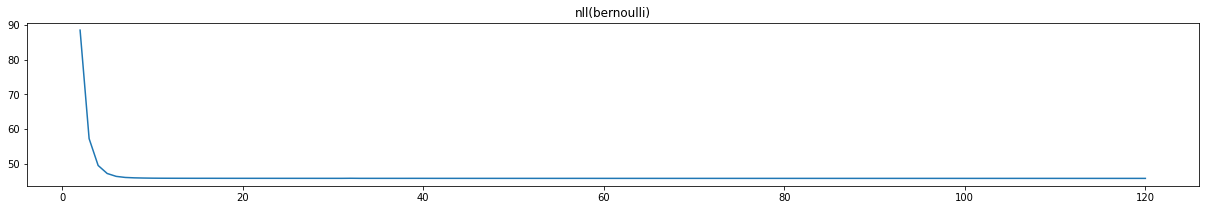

In [16]:
plt.figure(figsize=(21, 3))
plt.title('nll(bernoulli)')
plt.plot(range(2, 2+len(NLL[1:])), NLL[1:])
plt.show()

In [17]:
testdataset = datasets.MNIST(root='./mnist_data/', train=False, download=True).data

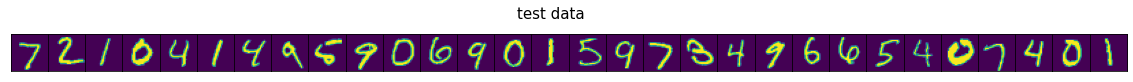

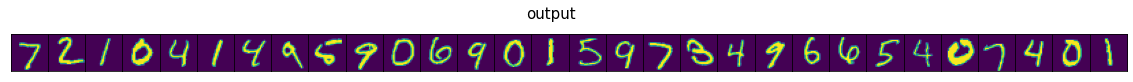

_


<Figure size 1440x144 with 0 Axes>

In [21]:

num_image = 30

fig = plt.figure(figsize=(20, 2))

n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(testdataset[n])
    n += 1
fig.suptitle('test data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
n = 0
for i in range(num_image):
    x_q = testdataset[n].reshape(1, 1, 28, 28).float().to(device) /255.0
    x_p = model(x_q)
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_p.cpu().data.numpy().reshape(28, 28))
    n += 1
model.train()
fig.suptitle('output', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
print('_')